# Next-Day Effect Analysis (v2)

This notebook explores lagged relationships between activities/sleep and next-day outcomes:

1. **Does running distance correlate with next-day stress?**
2. **Does bad sleep affect next-day stress?**

**Data Sources:**
- Daily metrics from BigQuery views (`v_daily_metrics`)
- Activity data from local JSON files (running, etc.)

## 1. Setup & Imports

In [ ]:
import os
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import warnings
warnings.filterwarnings('ignore')

# Paths
RAW_DIR = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/data/raw"
ACTIVITIES_DIR = os.path.join(RAW_DIR, "activities")

# BigQuery setup
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal-key.json"
bq_client = bigquery.Client()

print("Setup complete.")

## 2. Load Activity Data (Running)

In [2]:
# Load activities list
with open(os.path.join(ACTIVITIES_DIR, "activities_list.json"), "r") as f:
    activities = json.load(f)

print(f"Total activities: {len(activities)}")

# Filter running activities (outdoor + treadmill)
running_activities = [
    a for a in activities 
    if 'running' in a.get('activityType', {}).get('typeKey', '').lower()
]

print(f"Running activities: {len(running_activities)}")

# Convert to DataFrame
running_df = pd.DataFrame(running_activities)

# Extract date from startTimeLocal
running_df['date'] = pd.to_datetime(running_df['startTimeLocal']).dt.date
running_df['date'] = pd.to_datetime(running_df['date'])

# Select relevant columns
running_cols = [
    'date', 'activityName', 'distance', 'duration', 'movingDuration',
    'averageSpeed', 'maxSpeed', 'calories', 'averageHR', 'maxHR',
    'aerobicTrainingEffect', 'anaerobicTrainingEffect', 'steps',
    'differenceBodyBattery', 'vO2MaxValue'
]

# Only keep columns that exist
running_cols = [c for c in running_cols if c in running_df.columns]
running_df = running_df[running_cols].copy()

# Convert distance from meters to km
if 'distance' in running_df.columns:
    running_df['distance_km'] = running_df['distance'] / 1000

# Convert duration from seconds to minutes
if 'duration' in running_df.columns:
    running_df['duration_min'] = running_df['duration'] / 60

print(f"\nRunning data shape: {running_df.shape}")
running_df.head()

Total activities: 42
Running activities: 18

Running data shape: (18, 17)


,date,activityName,distance,duration,movingDuration,averageSpeed,maxSpeed,calories,averageHR,maxHR,aerobicTrainingEffect,anaerobicTrainingEffect,steps,differenceBodyBattery,vO2MaxValue,distance_km,duration_min
0,2026-01-24,Treadmill Running,2004.339966,962.789001,919.936005,2.082,2.547,169.0,163.0,189.0,3.3,1.0,2432,-4,NaN,2.00434,16.046483
1,2026-01-10,Treadmill Running,5016.169922,2429.021973,2417.901978,2.065,2.706,428.0,162.0,186.0,5.0,2.2,6250,-18,NaN,5.01617,40.483700
2,2026-01-09,Berlin - Benchmark Run,1120.180054,548.534973,547.000000,2.042,2.753,77.0,138.0,159.0,2.5,0.0,1352,-3,39.0,1.12018,9.142250
3,2026-01-04,Berlin - Temel,5535.740234,3124.256104,3094.848999,1.772,3.630,395.0,157.0,170.0,3.1,0.6,7988,-14,38.0,5.53574,52.070935
4,2026-01-02,Berlin - Temel,2308.530029,1385.187012,1383.365005,1.667,2.435,193.0,158.0,178.0,2.9,0.0,3560,-7,38.0,2.30853,23.086450


In [3]:
# Aggregate running data per day (in case of multiple runs)
running_daily = running_df.groupby('date').agg({
    'distance_km': 'sum',
    'duration_min': 'sum',
    'calories': 'sum',
    'averageHR': 'mean',
    'maxHR': 'max',
    'aerobicTrainingEffect': 'mean',
    'steps': 'sum'
}).reset_index()

running_daily.columns = ['date', 'run_distance_km', 'run_duration_min', 'run_calories', 
                          'run_avg_hr', 'run_max_hr', 'run_aerobic_effect', 'run_steps']

print(f"Days with running: {len(running_daily)}")
running_daily

Days with running: 18


,date,run_distance_km,run_duration_min,run_calories,run_avg_hr,run_max_hr,run_aerobic_effect,run_steps
0,2025-02-28,1.88000,23.296834,305.0,149.0,180.0,3.3,2464
1,2025-03-18,1.46124,10.371317,110.0,145.0,197.0,2.4,1628
2,2025-04-13,2.65872,20.090916,233.0,163.0,184.0,4.3,3186
3,2025-04-20,2.07205,15.003683,155.0,151.0,190.0,3.6,2338
4,2025-04-21,0.56310,4.663783,47.0,141.0,178.0,1.9,608
5,2025-05-21,1.39654,10.112866,133.0,178.0,192.0,3.9,1554
6,2025-10-12,2.15284,20.022249,218.0,151.0,176.0,3.5,2832
7,2025-12-10,2.01500,19.205550,225.0,162.0,186.0,4.2,2712
8,2025-12-16,5.00606,35.401652,359.0,157.0,187.0,4.3,5322
9,2025-12-28,5.00583,38.881868,388.0,175.0,195.0,4.8,6142


## 3. Load Daily Metrics from BigQuery

Using the pre-processed views instead of parsing JSON locally.

In [ ]:
# Load daily metrics from BigQuery view
query = """
SELECT 
    date,
    -- Sleep metrics
    sleep_hours,
    deep_sleep_hours,
    rem_sleep_hours,
    SAFE_DIVIDE(deep_sleep_hours, sleep_hours) * 100 AS deep_sleep_pct,
    SAFE_DIVIDE(rem_sleep_hours, sleep_hours) * 100 AS rem_sleep_pct,
    avg_overnight_hrv,
    -- Stress metrics
    avg_stress,
    max_stress,
    stress_category,
    -- Body battery
    charged,
    drained,
    net_battery,
    sleep_body_battery_change,
    -- Heart rate
    resting_hr,
    -- Steps (NULL for days with no data)
    steps,
    has_steps_data
FROM `garmin_data.v_daily_metrics`
ORDER BY date
"""

daily_df = bq_client.query(query).to_dataframe()

# Calculate sleep quality score (similar to Garmin's approach)
# Using deep sleep % and rem sleep % as primary indicators
daily_df['sleep_quality_score'] = (
    (daily_df['deep_sleep_pct'].fillna(0) / 20 * 35).clip(0, 35) +  # Deep sleep contribution
    (daily_df['rem_sleep_pct'].fillna(0) / 22 * 35).clip(0, 35) +   # REM contribution
    np.where(daily_df['sleep_hours'] < 7.5,
             (daily_df['sleep_hours'] / 7.5) * 30,
             30 - (daily_df['sleep_hours'] - 7.5) * 3).clip(0, 30)  # Duration contribution
).clip(0, 100)

print(f"Loaded {len(daily_df)} days from BigQuery")
print(f"Date range: {daily_df['date'].min()} to {daily_df['date'].max()}")
daily_df.head()

## 4. Merge Activity Data with Daily Metrics

In [ ]:
# Merge running data with daily metrics from BigQuery
merged = daily_df.copy()

# Merge with running data
merged = merged.merge(running_daily, on='date', how='left')

# Fill running days with 0 for non-running days
running_cols_fill = ['run_distance_km', 'run_duration_min', 'run_calories', 
                     'run_avg_hr', 'run_max_hr', 'run_aerobic_effect', 'run_steps']
for col in running_cols_fill:
    if col in merged.columns:
        merged[col] = merged[col].fillna(0)

# Create binary indicator for running days
merged['ran_today'] = (merged['run_distance_km'] > 0).astype(int)

print(f"Merged data shape: {merged.shape}")
print(f"Running days: {merged['ran_today'].sum()}")
merged.head()

## 5. Create Lagged Variables for Next-Day Analysis

In [ ]:
# Create NEXT-DAY (lagged) variables
# shift(-1) means: today's row gets tomorrow's value

merged['next_day_avg_stress'] = merged['avg_stress'].shift(-1)
merged['next_day_max_stress'] = merged['max_stress'].shift(-1)
merged['next_day_net_battery'] = merged['net_battery'].shift(-1)
merged['next_day_resting_hr'] = merged['resting_hr'].shift(-1)

# Drop rows with NaN in key analysis columns
analysis_df = merged.dropna(subset=['next_day_avg_stress', 'sleep_quality_score']).copy()

print(f"Analysis-ready data shape: {analysis_df.shape}")
print(f"Running days in analysis: {analysis_df['ran_today'].sum()}")
print(f"Non-running days: {(analysis_df['ran_today'] == 0).sum()}")

## 6. Merge All Data & Create Lagged Variables

*Merged in previous cells - this section preserved for notebook structure.*

In [ ]:
# Summary of analysis dataset
print("Analysis Dataset Summary:")
print(f"  Total days: {len(analysis_df)}")
print(f"  Date range: {analysis_df['date'].min()} to {analysis_df['date'].max()}")
print(f"  Running days: {analysis_df['ran_today'].sum()}")
print(f"\nKey columns:")
for col in ['avg_stress', 'next_day_avg_stress', 'sleep_hours', 'sleep_quality_score', 
            'net_battery', 'run_distance_km']:
    if col in analysis_df.columns:
        print(f"  {col}: {analysis_df[col].notna().sum()} non-null values")

In [ ]:
# Preview the lagged data structure
print("Lagged Variables Preview:")
print("(today's metrics → tomorrow's stress)")
analysis_df[['date', 'avg_stress', 'next_day_avg_stress', 'sleep_hours', 
             'run_distance_km', 'ran_today']].head(10)

---
# Analysis 1: Does Running Distance Correlate with Next-Day Stress?

**Hypothesis:** Running (especially longer distances) may either:
- Reduce next-day stress (stress relief, endorphins)
- Increase next-day stress (physical fatigue, overtraining)

In [9]:
# Compare running days vs non-running days
running_days = analysis_df[analysis_df['ran_today'] == 1]
non_running_days = analysis_df[analysis_df['ran_today'] == 0]

print("=" * 60)
print("NEXT-DAY STRESS: Running Days vs Non-Running Days")
print("=" * 60)
print(f"\nRunning days (n={len(running_days)}):")
print(f"  Next-day avg stress: {running_days['next_day_avg_stress'].mean():.2f} +/- {running_days['next_day_avg_stress'].std():.2f}")
print(f"\nNon-running days (n={len(non_running_days)}):")
print(f"  Next-day avg stress: {non_running_days['next_day_avg_stress'].mean():.2f} +/- {non_running_days['next_day_avg_stress'].std():.2f}")

# T-test
if len(running_days) > 2 and len(non_running_days) > 2:
    t_stat, p_value = stats.ttest_ind(
        running_days['next_day_avg_stress'].dropna(),
        non_running_days['next_day_avg_stress'].dropna()
    )
    print(f"\nT-test: t={t_stat:.3f}, p={p_value:.4f}")
    if p_value < 0.05:
        print("  -> Statistically significant difference!")
    else:
        print("  -> No statistically significant difference")

NEXT-DAY STRESS: Running Days vs Non-Running Days

Running days (n=17):
  Next-day avg stress: 35.47 +/- 9.07

Non-running days (n=316):
  Next-day avg stress: 41.16 +/- 8.04

T-test: t=-2.822, p=0.0051
  -> Statistically significant difference!


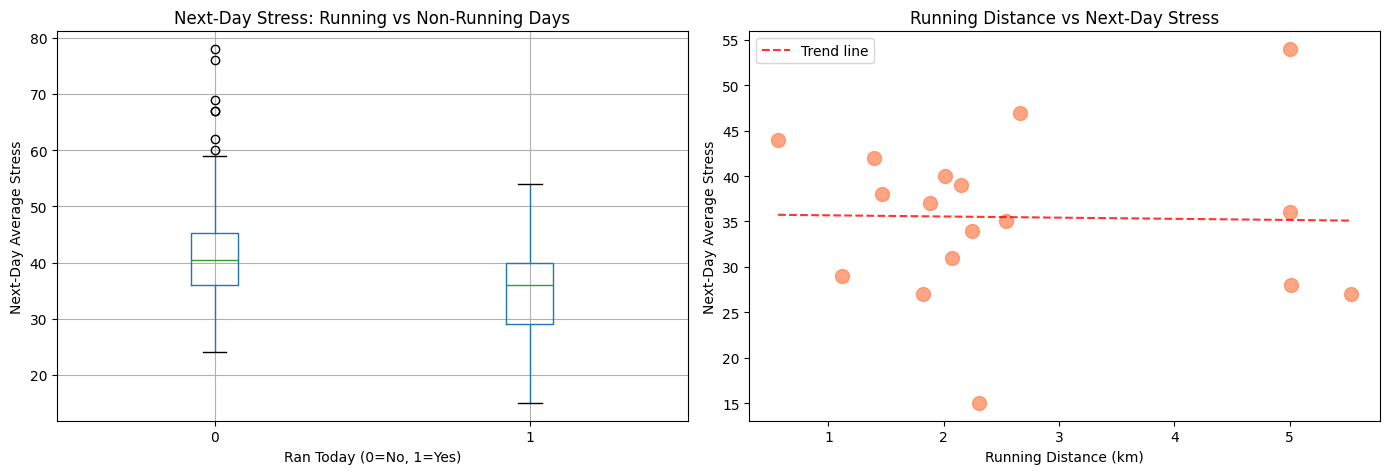

In [10]:
# Visualization: Running vs Non-Running Days
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
analysis_df.boxplot(column='next_day_avg_stress', by='ran_today', ax=ax1)
ax1.set_xlabel('Ran Today (0=No, 1=Yes)')
ax1.set_ylabel('Next-Day Average Stress')
ax1.set_title('Next-Day Stress: Running vs Non-Running Days')
plt.suptitle('')  # Remove automatic title

# Scatter: Distance vs Next-Day Stress (only running days)
ax2 = axes[1]
running_only = analysis_df[analysis_df['run_distance_km'] > 0]
if len(running_only) > 0:
    ax2.scatter(running_only['run_distance_km'], running_only['next_day_avg_stress'], 
                alpha=0.7, s=100, c='coral')
    
    # Add trend line
    if len(running_only) > 2:
        z = np.polyfit(running_only['run_distance_km'], running_only['next_day_avg_stress'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(running_only['run_distance_km'].min(), running_only['run_distance_km'].max(), 100)
        ax2.plot(x_line, p(x_line), "r--", alpha=0.8, label=f'Trend line')
        ax2.legend()

ax2.set_xlabel('Running Distance (km)')
ax2.set_ylabel('Next-Day Average Stress')
ax2.set_title('Running Distance vs Next-Day Stress')

plt.tight_layout()
plt.show()

In [11]:
# Correlation analysis for running metrics
print("=" * 60)
print("CORRELATION: Running Metrics vs Next-Day Stress")
print("=" * 60)

running_metrics = ['run_distance_km', 'run_duration_min', 'run_avg_hr', 
                   'run_aerobic_effect', 'run_calories']

# Only on running days
running_only = analysis_df[analysis_df['run_distance_km'] > 0].copy()

if len(running_only) > 3:
    print(f"\nAnalyzing {len(running_only)} running days:\n")
    for metric in running_metrics:
        if metric in running_only.columns:
            valid_data = running_only[[metric, 'next_day_avg_stress']].dropna()
            if len(valid_data) > 2:
                corr, p_val = stats.pearsonr(valid_data[metric], valid_data['next_day_avg_stress'])
                sig = "*" if p_val < 0.05 else ""
                print(f"{metric:25} r = {corr:+.3f}  (p = {p_val:.4f}) {sig}")
else:
    print("Not enough running days for correlation analysis")

CORRELATION: Running Metrics vs Next-Day Stress

Analyzing 17 running days:

run_distance_km           r = -0.022  (p = 0.9345) 
run_duration_min          r = -0.153  (p = 0.5567) 
run_avg_hr                r = +0.136  (p = 0.6030) 
run_aerobic_effect        r = +0.249  (p = 0.3359) 
run_calories              r = +0.010  (p = 0.9685) 


---
# Analysis 2: Does Bad Sleep Affect Next-Day Stress?

**Hypothesis:** Poor sleep quality leads to higher stress levels the following day.

In [12]:
# Categorize sleep quality
def categorize_sleep(score):
    if pd.isna(score):
        return 'Unknown'
    elif score >= 70:
        return 'Good'
    elif score >= 50:
        return 'Moderate'
    else:
        return 'Poor'

analysis_df['sleep_category'] = analysis_df['sleep_quality_score'].apply(categorize_sleep)

print("=" * 60)
print("NEXT-DAY STRESS BY SLEEP QUALITY CATEGORY")
print("=" * 60)

sleep_stress_summary = analysis_df.groupby('sleep_category').agg({
    'next_day_avg_stress': ['mean', 'std', 'count'],
    'sleep_quality_score': 'mean'
}).round(2)

print(sleep_stress_summary)

NEXT-DAY STRESS BY SLEEP QUALITY CATEGORY
               next_day_avg_stress              sleep_quality_score
                              mean    std count                mean
sleep_category                                                     
Good                         40.88   8.15   327               99.38
Moderate                     37.75   7.09     4               60.47
Poor                         45.50  17.68     2                0.00


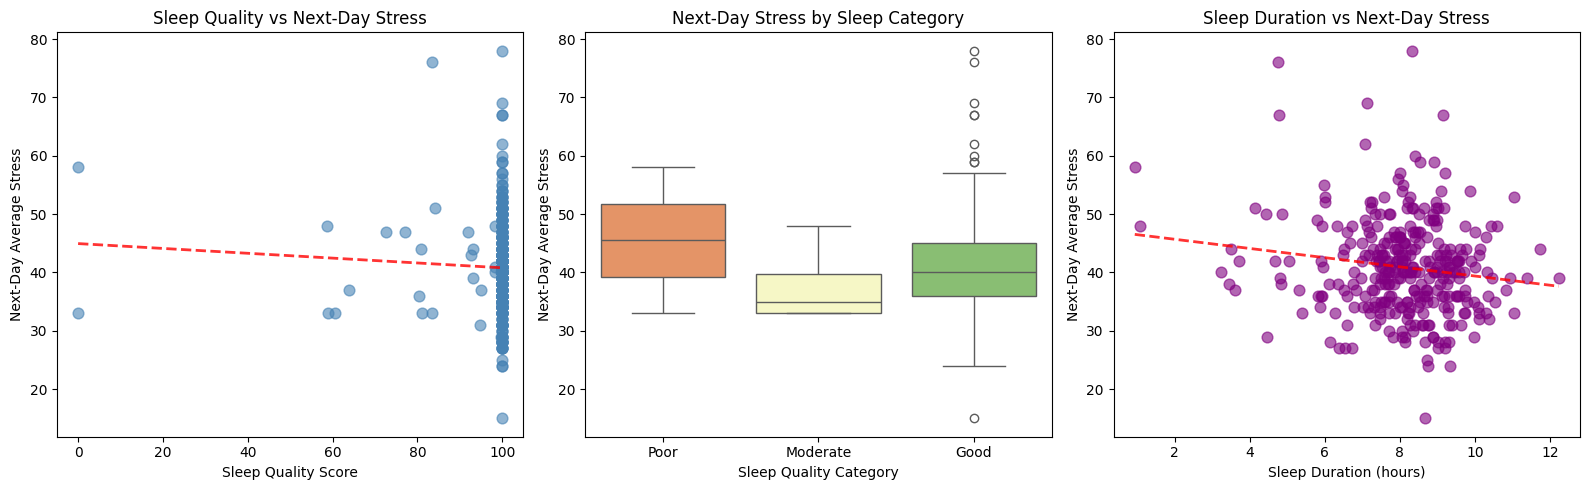

In [13]:
# Visualization: Sleep Quality vs Next-Day Stress
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Scatter plot: Sleep Quality Score vs Next-Day Stress
ax1 = axes[0]
ax1.scatter(analysis_df['sleep_quality_score'], analysis_df['next_day_avg_stress'], 
            alpha=0.6, s=60, c='steelblue')

# Add trend line
valid = analysis_df[['sleep_quality_score', 'next_day_avg_stress']].dropna()
if len(valid) > 2:
    z = np.polyfit(valid['sleep_quality_score'], valid['next_day_avg_stress'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid['sleep_quality_score'].min(), valid['sleep_quality_score'].max(), 100)
    ax1.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

ax1.set_xlabel('Sleep Quality Score')
ax1.set_ylabel('Next-Day Average Stress')
ax1.set_title('Sleep Quality vs Next-Day Stress')

# 2. Box plot by category
ax2 = axes[1]
order = ['Poor', 'Moderate', 'Good']
categories_present = [c for c in order if c in analysis_df['sleep_category'].unique()]
sns.boxplot(data=analysis_df, x='sleep_category', y='next_day_avg_stress', 
            order=categories_present, ax=ax2, palette='RdYlGn')
ax2.set_xlabel('Sleep Quality Category')
ax2.set_ylabel('Next-Day Average Stress')
ax2.set_title('Next-Day Stress by Sleep Category')

# 3. Sleep Hours vs Next-Day Stress
ax3 = axes[2]
ax3.scatter(analysis_df['sleep_hours'], analysis_df['next_day_avg_stress'], 
            alpha=0.6, s=60, c='purple')

valid_hours = analysis_df[['sleep_hours', 'next_day_avg_stress']].dropna()
if len(valid_hours) > 2:
    z = np.polyfit(valid_hours['sleep_hours'], valid_hours['next_day_avg_stress'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid_hours['sleep_hours'].min(), valid_hours['sleep_hours'].max(), 100)
    ax3.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

ax3.set_xlabel('Sleep Duration (hours)')
ax3.set_ylabel('Next-Day Average Stress')
ax3.set_title('Sleep Duration vs Next-Day Stress')

plt.tight_layout()
plt.show()

In [14]:
# Correlation analysis for sleep metrics
print("=" * 60)
print("CORRELATION: Sleep Metrics vs Next-Day Stress")
print("=" * 60)

sleep_metrics = ['sleep_quality_score', 'sleep_hours', 'deep_sleep_pct', 
                 'rem_sleep_pct', 'awake_pct']

print("\n")
for metric in sleep_metrics:
    if metric in analysis_df.columns:
        valid_data = analysis_df[[metric, 'next_day_avg_stress']].dropna()
        if len(valid_data) > 2:
            corr, p_val = stats.pearsonr(valid_data[metric], valid_data['next_day_avg_stress'])
            sig = "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            direction = "(more -> higher stress)" if corr > 0 else "(more -> lower stress)"
            print(f"{metric:25} r = {corr:+.3f}  (p = {p_val:.4f}) {sig} {direction}")

CORRELATION: Sleep Metrics vs Next-Day Stress


sleep_quality_score       r = -0.047  (p = 0.3902)  (more -> lower stress)
sleep_hours               r = -0.146  (p = 0.0082) ** (more -> lower stress)
deep_sleep_pct            r = +0.038  (p = 0.4888)  (more -> higher stress)
rem_sleep_pct             r = +0.004  (p = 0.9389)  (more -> higher stress)
awake_pct                 r = +0.077  (p = 0.1627)  (more -> higher stress)


In [15]:
# ANOVA test across sleep categories
print("\n" + "=" * 60)
print("ANOVA: Sleep Quality Categories")
print("=" * 60)

groups = []
for cat in ['Poor', 'Moderate', 'Good']:
    group_data = analysis_df[analysis_df['sleep_category'] == cat]['next_day_avg_stress'].dropna()
    if len(group_data) > 0:
        groups.append(group_data)
        print(f"{cat}: n={len(group_data)}, mean={group_data.mean():.2f}")

if len(groups) >= 2:
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nANOVA: F={f_stat:.3f}, p={p_value:.4f}")
    if p_value < 0.05:
        print("  -> Significant difference between sleep quality groups!")
    else:
        print("  -> No significant difference between groups")


ANOVA: Sleep Quality Categories
Poor: n=2, mean=45.50
Moderate: n=4, mean=37.75
Good: n=327, mean=40.88

ANOVA: F=0.610, p=0.5439
  -> No significant difference between groups


---
# Analysis 3: Combined Model - Predicting Next-Day Stress

In [16]:
# Multiple regression: Predict next-day stress from sleep + running
print("=" * 60)
print("MULTIPLE REGRESSION: Predicting Next-Day Stress")
print("=" * 60)

# Features for prediction
features = ['sleep_quality_score', 'sleep_hours', 'deep_sleep_pct', 
            'run_distance_km', 'ran_today', 'avg_stress']  # Include same-day stress as baseline

# Prepare data
model_df = analysis_df[features + ['next_day_avg_stress']].dropna()
print(f"\nSamples for modeling: {len(model_df)}")

if len(model_df) > 10:
    X = model_df[features]
    y = model_df['next_day_avg_stress']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_scaled, y)
    
    # Results
    r2 = model.score(X_scaled, y)
    print(f"\nR-squared: {r2:.3f} ({r2*100:.1f}% variance explained)")
    
    print("\nFeature Coefficients (standardized):")
    print("-" * 40)
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    for _, row in coef_df.iterrows():
        direction = "+" if row['Coefficient'] > 0 else "-"
        print(f"  {row['Feature']:25} {direction} {abs(row['Coefficient']):.3f}")
else:
    print("Not enough data for regression model")

MULTIPLE REGRESSION: Predicting Next-Day Stress

Samples for modeling: 326

R-squared: 0.106 (10.6% variance explained)

Feature Coefficients (standardized):
----------------------------------------
  avg_stress                + 2.536
  ran_today                 - 0.755
  sleep_quality_score       + 0.554
  deep_sleep_pct            + 0.476
  sleep_hours               - 0.117
  run_distance_km           + 0.084


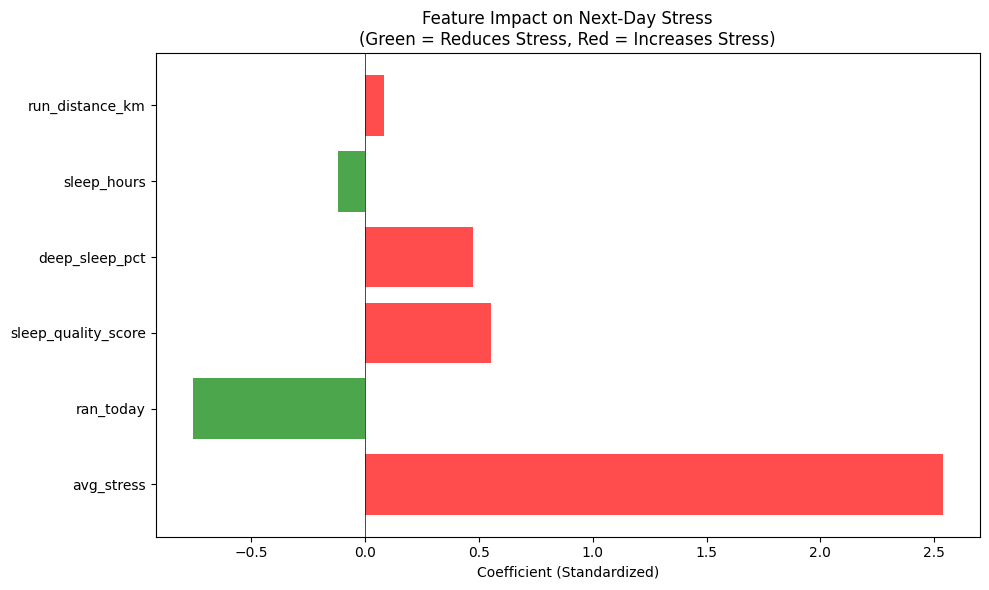

In [17]:
# Visualize feature importance
if len(model_df) > 10:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['green' if c < 0 else 'red' for c in coef_df['Coefficient']]
    bars = ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
    
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlabel('Coefficient (Standardized)')
    ax.set_title('Feature Impact on Next-Day Stress\n(Green = Reduces Stress, Red = Increases Stress)')
    
    plt.tight_layout()
    plt.show()

---
# Summary & Key Findings

In [18]:
print("=" * 70)
print("SUMMARY: Next-Day Effect Analysis")
print("=" * 70)

print("\n1. RUNNING AND NEXT-DAY STRESS")
print("-" * 40)
if len(running_days) > 0 and len(non_running_days) > 0:
    diff = running_days['next_day_avg_stress'].mean() - non_running_days['next_day_avg_stress'].mean()
    direction = "higher" if diff > 0 else "lower"
    print(f"  - Running days have {abs(diff):.1f} points {direction} next-day stress")
    print(f"  - Running days: {running_days['next_day_avg_stress'].mean():.1f} avg stress")
    print(f"  - Non-running days: {non_running_days['next_day_avg_stress'].mean():.1f} avg stress")

print("\n2. SLEEP AND NEXT-DAY STRESS")
print("-" * 40)
sleep_corr = analysis_df[['sleep_quality_score', 'next_day_avg_stress']].dropna()
if len(sleep_corr) > 2:
    r, p = stats.pearsonr(sleep_corr['sleep_quality_score'], sleep_corr['next_day_avg_stress'])
    print(f"  - Sleep quality correlation with next-day stress: r = {r:.3f}")
    if r < 0:
        print(f"  - Better sleep quality is associated with LOWER next-day stress")
    else:
        print(f"  - Better sleep quality is associated with HIGHER next-day stress (unexpected)")

print("\n3. RECOMMENDATIONS")
print("-" * 40)
print("  - Track more running sessions to increase statistical power")
print("  - Consider the cumulative effect (multiple days of poor sleep)")
print("  - Add recovery days between intense runs to optimize stress levels")

SUMMARY: Next-Day Effect Analysis

1. RUNNING AND NEXT-DAY STRESS
----------------------------------------
  - Running days have 5.7 points lower next-day stress
  - Running days: 35.5 avg stress
  - Non-running days: 41.2 avg stress

2. SLEEP AND NEXT-DAY STRESS
----------------------------------------
  - Sleep quality correlation with next-day stress: r = -0.047
  - Better sleep quality is associated with LOWER next-day stress

3. RECOMMENDATIONS
----------------------------------------
  - Track more running sessions to increase statistical power
  - Consider the cumulative effect (multiple days of poor sleep)
  - Add recovery days between intense runs to optimize stress levels


In [19]:
# Export analysis-ready dataset for further exploration
output_path = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/data/processed/next_day_analysis.csv"
analysis_df.to_csv(output_path, index=False)
print(f"\nExported analysis data to: {output_path}")
print(f"Shape: {analysis_df.shape}")


Exported analysis data to: /Users/tolgasabanoglu/Desktop/github/spatiotemporal/data/processed/next_day_analysis.csv
Shape: (333, 24)
